In [2]:
import cv2
import os

# import argparse
# parser = argparse.ArgumentParser(description='control SRCNN')
# parser.add_argument('--to', action="store",dest="tryout", default=20)
# parser.add_argument('--ep', action="store",dest="epochs", default=50)
# parser.add_argument('--bs', action="store",dest="batch_size", default=64)
# parser.add_argument('--lr', action="store",dest="learning_rate", default=0.0001)
# parser.add_argument('--gpu', action="store",dest="gpu", default=1)

# values = parser.parse_args()
gpu=0
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu)

import sys
import numpy as np
import matplotlib.pyplot as plt
from CREATE_DATA_SET import PARSE_DATA
from keras.models import Model
from keras.layers import Input, Convolution2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as k
import tensorflow as tf

folder = '../sibling-face-data/DBs'
HEIGHT = 120
WIDTH = 160
CHANNEL = 3
pd = PARSE_DATA(folder  , WIDTH= WIDTH , HEIGHT=HEIGHT)

data = pd.get_train_data()
lr_data_2x = pd.get_2x_lower()

print(data.shape)
print(lr_data_2x.shape)

def PSNRLoss(y_true, y_pred):
    return 10* k.log(k.mean(k.square(y_pred - y_true)))

Using TensorFlow backend.


(1080, 120, 160, 3)
(1080, 60, 80, 3)


In [12]:
class SRCNN:
  def __init__(self,width , height , channel , lr):
    self.height = height
    self.width = width
    inputs = Input(shape=(height, width , channel))
    x = Convolution2D(64, (9, 9), activation='relu', init='he_normal' , border_mode='same')(inputs)
    x = Convolution2D(32, (1, 1), activation='relu', init='he_normal' , border_mode='same')(x)
    x = Convolution2D(3, (5, 5), init='he_normal' , border_mode='same')(x)
    self.model = Model(input = inputs, output = x)
    adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
    self.model.compile(loss='mse', optimizer=adam , metrics=[PSNRLoss])
    self.model.summary()
    input()
    
  def fit(self , X , Y ,batch_size=64 , epoch = 100 , gpu=0 ):
    X = np.array([cv2.resize(image, dsize=(self.width , self.height), interpolation=cv2.INTER_CUBIC) for image in X])
    # with tf.device('/gpu:'+str(gpu)):
    for i in range(epoch):    
        print("epoch: ",i)
        out = self.model.fit(X, Y , batch_size = batch_size , verbose =1 , nb_epoch=1)
  
  def get_model(self):
    return self.model

  def generate(self , X ):
    X = cv2.resize(X, dsize=(self.width , self.height), interpolation=cv2.INTER_CUBIC)
    return self.model.predict(np.array([X]))

In [26]:
learning_rate = 0.0001
batch_size = 32
epochs = 50
tryout = 1000


In [ ]:
from PIL import Image

lr_data_8x = pd.get_8x_lower()
Y_data = pd.get_train_data()

model = SRCNN(WIDTH , HEIGHT , CHANNEL , learning_rate)

Image.fromarray(Y_data[0]).save("test_image.jpeg")
Image.fromarray(lr_data_2x[0]).save("test_image_2x.jpeg")



In [23]:
def train():
    for i in range (tryout):
        print("tryout no: ",i)
        model.fit( lr_data_8x, Y_data , epoch = epochs , batch_size=batch_size , gpu = gpu)
        im = model.generate(lr_data_2x[0])[0]
        Image.fromarray(im.astype('uint8')).save("test_image_2x_"+str(i)+"_.jpeg")

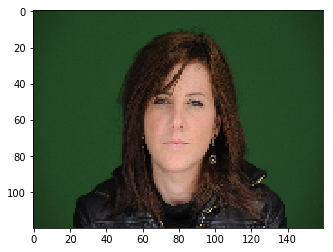

In [16]:
plt.imshow(Y_data[0])

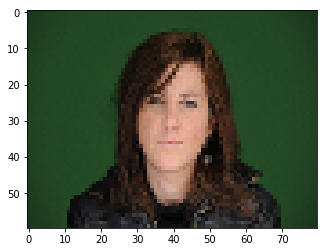

In [5]:
plt.imshow(lr_data_2x[0])

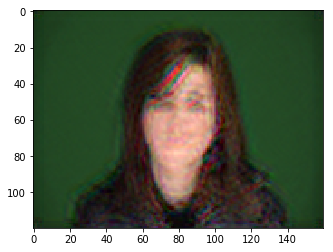

In [22]:
im = model.generate(lr_data_2x[0])[0]
im[im > 255] = 255
im[im < 0] = 0
im = np.array(im , np.uint8)
plt.imshow(im)

In [ ]:
train()

In [29]:
md = model.get_model()
md.save('SRCNN_direct_Conv_1100epoch.h5')
del md

In [ ]:
from keras.models import load_model
model = load_model('SRCNN_direct_Conv_1100epoch.h5')
model.fit()